In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
%matplotlib inline

In [105]:
plt.rcParams['figure.figsize'] = 15, 8
# plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

# Task 7

In [8]:
G = nx.read_adjlist("graph.txt", nodetype=int, create_using=nx.DiGraph())

**Проверим, что при считывании не потерялись условия задачи**

In [9]:
len(G.edges)

5105039

In [10]:
len(G.nodes)

875713

In [11]:
nx.is_directed(G)

True

In [12]:
from collections import defaultdict

def get_degrees_distr(G: nx.Graph):
    degrees = defaultdict(int)

    for v in G.nodes():
        d = G.degree(v)
        degrees[d] += 1
    return degrees

In [13]:
degrees = get_degrees_distr(G)

In [20]:
_degrees, _amounts = zip(*sorted(degrees.items(), key=lambda x: x[0]))

In [25]:
cumulative_amounts = np.array(_amounts).cumsum()

In [26]:
cumulative_dict = {k: v for k, v in zip(_degrees, cumulative_amounts)} 

In [31]:
def plot_degrees(degrees: defaultdict, _type=None):
    plt.loglog(degrees.keys(), degrees.values(), ls=None, marker='.')
    if _type is None:
        plt.title("Распределение степеней вершин")  
        plt.ylabel("Число вершин")
    else:
        plt.title(f"{_type} распределение степеней вершин")  
        plt.ylabel(f"{_type} число вершин")
    plt.xlabel("Полная cтепень вершины")

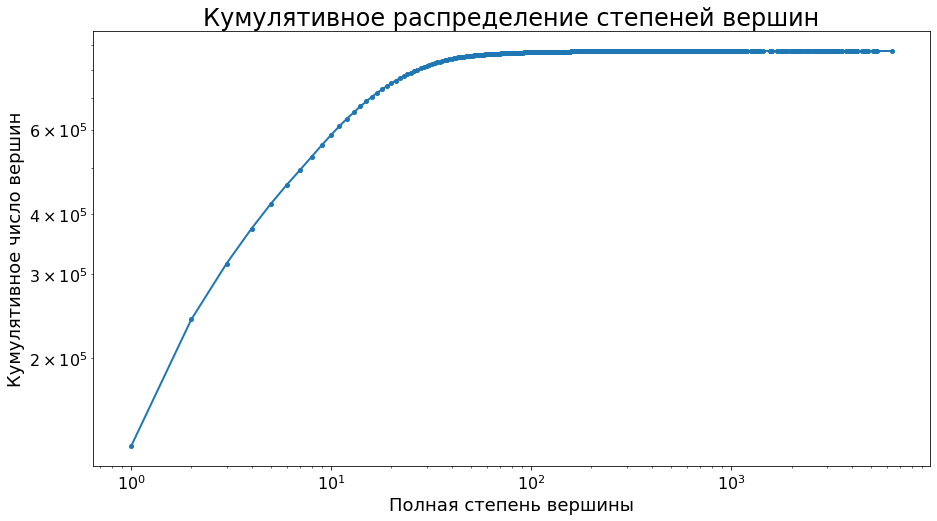

In [103]:
plot_degrees(cumulative_dict, _type="Кумулятивное")

In [130]:
from scipy.optimize import curve_fit

power_law = lambda d, c, gamma: c / (d**gamma)

_degrees = np.array(_degrees)
main_part_mask = (_degrees < np.quantile(_degrees, 0.03)) & (_degrees >= 1)
opt_params, opt_covar = curve_fit(power_law, _degrees[main_part_mask], cumulative_amounts[main_part_mask])

In [131]:
cumulative_amounts[main_part_mask]

array([130912, 240887, 315135, 372868, 420174, 460112, 494511, 527222,
       557590, 585054, 610277, 632700, 652445, 670909, 687583, 702860,
       716588, 728608, 739713, 750075, 759430, 767911, 775635],
      dtype=int32)

In [132]:
opt_params

array([ 2.03618063e+05, -4.41557998e-01])

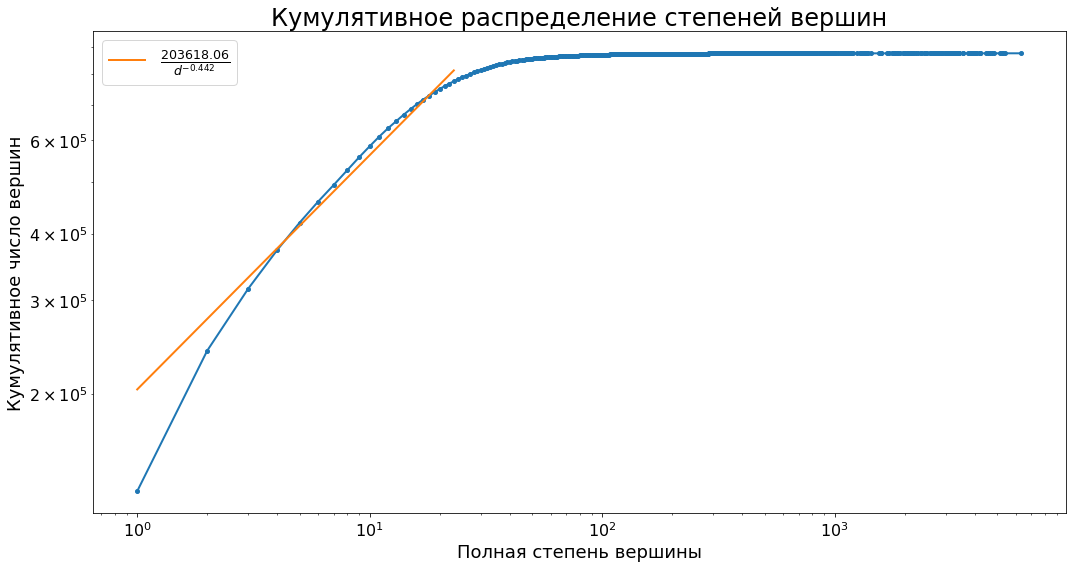

In [133]:
plot_degrees(cumulative_dict, _type="Кумулятивное")
plt.loglog(_degrees[main_part_mask], 
           power_law(_degrees[main_part_mask],
                     opt_params[0], opt_params[1]), 
           label=r"$\frac{" + f"{opt_params[0]:.2f}" + "}{d^{" + f"{opt_params[1]:.3f}" + "}}$")
plt.legend()
plt.tight_layout()
plt.savefig("graph_6.jpg")

# Task 8

In [170]:
def J(A: set, B: set):
    return len(A.intersection(B)) / len(A.union(B))

In [171]:
def Jaccard(G: nx.Graph, e: (int, int)):
    N_u = set(G.neighbors(e[0]))
    N_v = set(G.neighbors(e[1]))
    return J(N_u, N_v)

In [172]:
def J_G(G: nx.Graph):
    edges_J = list(map(lambda x: Jaccard(G, x), G.edges))
    return np.mean(edges_J)
        

**Проверим на полном графе $K_4$. Должно быть 0.5**

In [173]:
G = nx.complete_graph(4)

In [174]:
J_G(G)

0.5

Отлично. Приступим к основному заданию

In [175]:
n = 300
_step = 0.05
p_range = np.arange(0, 1+_step, _step) 

In [176]:
from tqdm.notebook import tqdm

J_values = []
for p in tqdm(p_range):
    _G = nx.erdos_renyi_graph(n=n, p=p)
    J_values.append(J_G(_G))

  0%|          | 0/21 [00:00<?, ?it/s]

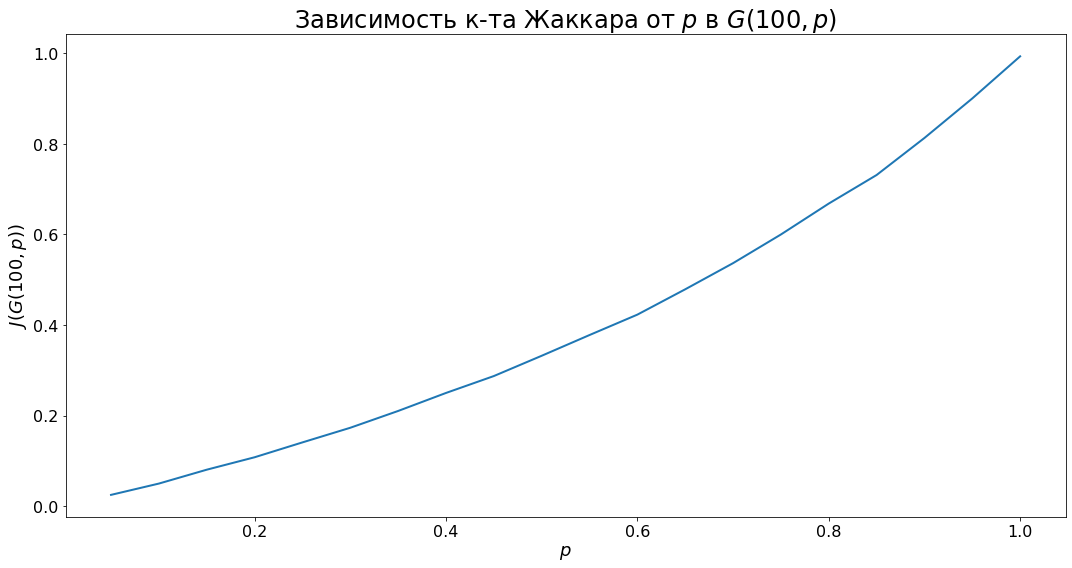

In [179]:
plt.plot(p_range, J_values)
plt.title(r"Зависимость к-та Жаккара от $p$ в $G(100, p)$")
plt.xlabel(r"$p$")
plt.ylabel(r"$J\left(G(100, p)\right)$")
plt.tight_layout()
plt.savefig("graph_7.jpg")

# Task 9

**Спарсим данные, если позволят)**

In [180]:
import requests

In [195]:
url = lambda x: f"https://www.livejournal.com/misc/fdata.bml?user={x}"

head_usr = "varlamovru"

with open("parsed_friends.txt", "w") as f:
    r = requests.get(url(head_usr), allow_redirects=True)
    contents_list = r.content.decode("utf-8").split('\n')
    contents_list = [c for c in contents_list if ">" in c or "<" in c]
    f.writelines([string.replace(">", f"{head_usr} ") + "\n" if ">" in string else
                  string.replace("< ", "") + f" {head_usr}" + "\n" 
                  for string in contents_list])
    
    unique_friends = np.unique([c.strip("<>") for c in contents_list])
    for friend in tqdm(unique_friends):
        r = requests.get(url(friend), allow_redirects=True)
        contents_list = r.content.decode("utf-8").split('\n')
        contents_list = [c for c in contents_list if ">" in c or "<" in c]
        f.writelines([string.replace(">", f"{friend} ") + "\n" if ">" in string else
                      string.replace("< ", "") + f" {friend}" + "\n" 
                      for string in contents_list])

  0%|          | 0/2781 [00:00<?, ?it/s]

**Теперь считаем**

In [196]:
G = nx.read_adjlist("parsed_friends.txt", nodetype=str, create_using=nx.DiGraph())

In [203]:
len(G.nodes)

333729

In [204]:
len(G.edges)

1645373

In [197]:
nx.is_directed(G)

True

In [202]:
print(f"Локальный кластерный коэффициент для {head_usr} = {nx.clustering(G, nodes=[head_usr])[head_usr]}")

Локальный кластерный коэффициент для varlamovru = 0.008826727372987425


In [206]:
print(f"Локальный кластерный коэффициент для {head_usr} = {nx.average_clustering(G, nodes=[head_usr])}")

Локальный кластерный коэффициент для varlamovru = 0.008826727372987425


**Визуализацию будем проводить через Gephi)**